# Modeling Night-Time Aircraft Noise Complaints

In this section, we build a predictive model to estimate the number of night-time aircraft noise complaints per neighborhood and test “what-if” scenarios such as increasing aircraft altitude. We use CatBoost Regressor because it efficiently handles both numerical and categorical features, requires minimal preprocessing for categorical variables, and performs well on non-linear and skewed data.

Our features include:

- Categorical: aircraft_type, operation_type

- Numerical: aircraft_pca_altitude, distance_to_sfo_km, population

- Time features: Cyclical transformations of hour and a late-night indicator

### Import library

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
import seaborn as sns



### Load and Prepare Dataset

We load the aircraft noise complaints dataset and the ZIP code latitude/longitude data to compute distances from each reporter’s location to SFO. Distance is included because neighborhoods closer to the airport generally report more complaints.

In [ ]:
# Load complaint dataset
df = pd.read_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv")
df['reporter_postal_code'] = df['reporter_postal_code'].astype(str).str.zfill(5)
df['hour'] = df['hour'].astype(int)
df['aircraft_type'] = df['aircraft_type'].astype(str)
df['operation_type'] = df['operation_type'].astype(str)

# Load ZIP lat/lon and population data
zip_df = pd.read_csv("../data/uszips.csv")
zip_df['zip'] = zip_df['zip'].astype(str).str.zfill(5)

# Merge to include lat/lon and population
df = df.merge(
    zip_df[['zip','lat','lng','population']],
    left_on='reporter_postal_code',
    right_on='zip',
    how='left'
)


/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_56962/185322205.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv")


### Compute Distance to SFO

We calculate the distance from each reporter to SFO using the Haversine formula. This gives the model a feature for proximity to the airport.

In [ ]:
def haversine(lat1, lon1, lat2=37.6213, lon2=-122.3790):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(np.sqrt(a))
    r = 6371
    return c * r

df['distance_to_sfo_km'] = df.apply(lambda x: haversine(x['lat'], x['lng']), axis=1)


### Aggregate Complaints

We group the data by city, hour, operation type, and aircraft type, then compute average altitude, distance, population, and complaint counts. This creates a clean, structured dataset for modeling.

In [ ]:
agg = df.groupby(['reporter_city', 'hour', 'operation_type', 'aircraft_type']).agg({
    'aircraft_pca_altitude': 'mean',
    'distance_to_sfo_km': 'mean',
    'population': 'mean'
}).reset_index()

agg['complaint_count'] = df.groupby(['reporter_city', 'hour', 'operation_type', 'aircraft_type']).size().values


### Feature Engineering

We create features to help the model capture temporal patterns and nighttime effects:

- Cyclical hour features: hour_sin and hour_cos encode the circular nature of hours

- Late-night indicator: is_late_night marks complaints from 8 PM to 7 AM

In [37]:
agg['hour_sin'] = np.sin(2*np.pi*agg['hour']/24)
agg['hour_cos'] = np.cos(2*np.pi*agg['hour']/24)
agg['is_late_night'] = agg['hour'].apply(lambda x: 1 if x>=20 or x<=4 else 0)


### Prepare Model Inputs

Categorical features are converted to category type. The target complaint_count is log-transformed to reduce skewness.

In [ ]:
categorical_cols = ['operation_type','aircraft_type']
for col in categorical_cols:
    agg[col] = agg[col].astype('category')

agg['log_complaints'] = np.log1p(agg['complaint_count'])

features = ['aircraft_pca_altitude', 'distance_to_sfo_km', 'population',
            'hour_sin','hour_cos','is_late_night','operation_type','aircraft_type']
X = agg[features]
y = agg['log_complaints']


### Train CatBoost Model

We train using 5-fold cross-validation and evaluate using R² and MAE on the original scale

In [38]:
model = CatBoostRegressor(
    iterations=500,
    depth=10,
    learning_rate=0.1,
    loss_function='RMSE',
    random_seed=42,
    verbose=100,
    task_type='CPU'
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores, mae_scores = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train, cat_features=categorical_cols, verbose=False)
    y_pred = model.predict(X_test)
    
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)
    
    r2_scores.append(r2_score(y_test_orig, y_pred_orig))
    mae_scores.append(mean_absolute_error(y_test_orig, y_pred_orig))

print("Mean R²:", np.mean(r2_scores))
print("Mean MAE:", np.mean(mae_scores))


Mean R²: 0.5896602116600531
Mean MAE: 57.953525442555794


### Scenario Analysis

We test the impact of increasing aircraft altitude by 1,000 ft on predicted complaints.

     reporter_city  avg_change_in_complaints
0       Santa Cruz               -157.854768
1        Palo Alto               -127.135380
2           Soquel                -69.155734
3        Los Altos                -63.972602
4    Scotts Valley                -42.925775
5  Los Altos Hills                -35.791936
6   Portola Valley                -25.153405
7    Mountain View                -23.126804
8        Los Gatos                -16.407299
9      Foster City                -13.555902


/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_56962/868802896.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


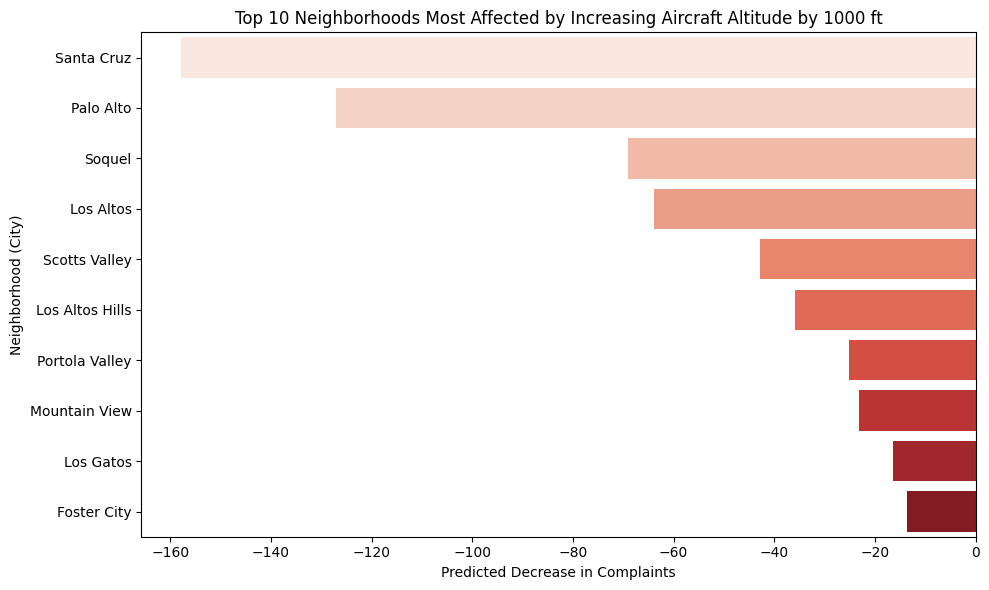

In [40]:
X_scenario = X.copy()
X_scenario['aircraft_pca_altitude'] += 1000

y_scenario_pred = model.predict(X_scenario)
y_scenario_pred_orig = np.expm1(y_scenario_pred)
y_orig_pred = np.expm1(model.predict(X))

agg['predicted_change'] = y_scenario_pred_orig - y_orig_pred

top10_neighborhoods = agg.groupby('reporter_city')['predicted_change'].mean().nsmallest(10).reset_index()
top10_neighborhoods.columns = ['reporter_city','avg_change_in_complaints']
top10_neighborhoods = top10_neighborhoods.sort_values(by='avg_change_in_complaints')

print(top10_neighborhoods)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10_neighborhoods,
    x='avg_change_in_complaints',
    y='reporter_city',
    palette=sns.color_palette("Reds", n_colors=top10_neighborhoods.shape[0])
)
plt.title("Top 10 Neighborhoods Most Affected by Increasing Aircraft Altitude by 1000 ft")
plt.xlabel("Predicted Decrease in Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


The plot shows predicted reductions in complaints if altitude is increased. Santa Cruz sees the largest drop (~158 fewer complaints), while Emerald Hills sees the smallest (~14 fewer complaints). This highlights how operational changes can reduce noise impact for neighborhoods most affected by low-flying aircraft.